# Mounting Google Drive



In [1]:
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


In [2]:
cd /content/drive/My\ Drive/

/content/drive/My Drive


In [3]:
%ls

 best-model-16-5.pt                   init_params.pt
 best-model-16-7.pt                  'La Ronde'/
 best-model-64-1.pt                   test/
 best-model-64-5.pt                  'Toronto and Niagara'/
'Colab Notebooks'/                    train/
'How to get started with Drive.pdf'


# Downloading and Extracting Dataset

In [ ]:
!pip install gdown
!gdown https://drive.google.com/u/0/uc?id=1e_hA12vldgKN3L_bBx9gLKPQO8n49gc-

Downloading...
From: https://drive.google.com/u/0/uc?id=1e_hA12vldgKN3L_bBx9gLKPQO8n49gc-
To: /content/drive/My Drive/VideoKen/frame-dataset.tar.gz
5.88GB [02:03, 47.4MB/s]


In [ ]:
!tar -xvzf frame-dataset.tar.gz

Streaming output truncated to the last 5000 lines.
frame-dataset/slides/3aYYrzl3xzk_key_frame_3_0.png
frame-dataset/slides/abfiU1DAjj0_key_frame_5_0.png
frame-dataset/slides/vdocipher-8f31b10e49e8470daa06aa9797fe4675_key_frame_35_0.png
frame-dataset/slides/w8rLW6magqs_key_frame_63_0.png
frame-dataset/slides/X2s9GXXhmCY_key_frame_0_0.png
frame-dataset/slides/LZUKHhwtpFU_key_frame_43_0.png
frame-dataset/slides/6ZJzfRdCZjc_key_frame_82_1.png
frame-dataset/slides/vtxwXSGl9V8_key_frame_20_0.png
frame-dataset/slides/b3pcKr_vSyk_key_frame_48_0.png
frame-dataset/slides/BHKpsgL789I_key_frame_128_0.png
frame-dataset/slides/b3pcKr_vSyk_key_frame_5_12.png
frame-dataset/slides/DF-CBYioA_c_key_frame_156_0.png
frame-dataset/slides/D1m2K-zybf0_key_frame_44_0.png
frame-dataset/slides/0sApcfs0gBg_key_frame_2_0.png
frame-dataset/slides/UFCG_rCNDuE_key_frame_65_0.png
frame-dataset/slides/1M9B2I01X_k_key_frame_543_1.png
frame-dataset/slides/-RD53zPzII4_key_frame_0_0.png
frame-dataset/slides/1DJoi7N5TvI_key

# Importing Packages

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

# Splitting train-test sets

In [6]:
TRAIN_RATIO = 0.8
ROOT = '/content/drive/My Drive'
images_dir = os.path.join(ROOT, 'frame-dataset')
train_dir = os.path.join(ROOT, 'train')
test_dir = os.path.join(ROOT, 'test')

In [ ]:
# if os.path.exists(train_dir):
#     shutil.rmtree(train_dir) 
# if os.path.exists(test_dir):
#     shutil.rmtree(test_dir)  

os.makedirs(train_dir)
os.makedirs(test_dir)

classes = os.listdir(images_dir)
print(classes)

for c in classes:
    class_dir = os.path.join(images_dir, c)
    images = os.listdir(class_dir)
    random.shuffle(images)
    n_train = int(len(images) * TRAIN_RATIO)
    train_images = images[:n_train]
    test_images = images[n_train:]
    os.makedirs(os.path.join(train_dir, c), exist_ok = True)
    os.makedirs(os.path.join(test_dir, c), exist_ok = True)
    
    for image in train_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(train_dir, c, image) 
        shutil.move(image_src, image_dst)
        
    for image in test_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(test_dir, c, image) 
        shutil.move(image_src, image_dst)

['misc', 'handwritten', 'slides', 'codewalk']


# Count of images in Train and Test Datasets

In [ ]:
%%bash
cd train/
cd codewalk/
ls -1 | wc -l
cd ../handwritten/
ls -1 | wc -l
cd ../misc/
ls -1 | wc -l
cd ../slides/
ls -1 | wc -l
cd ../../test/
cd codewalk/
ls -1 | wc -l
cd ../handwritten/
ls -1 | wc -l
cd ../misc/
ls -1 | wc -l
cd ../slides/
ls -1 | wc -l

3363
5063
3630
4516
841
1266
908
1129


# Data Augmentation

In [7]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])


In [8]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

# Validation Split

In [9]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [10]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

# Count of Train, Val and Test Sets

In [11]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 14914
Number of validation examples: 1658
Number of testing examples: 4144


In [12]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)
test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

# Visualizing few images from dataset

In [13]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [14]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

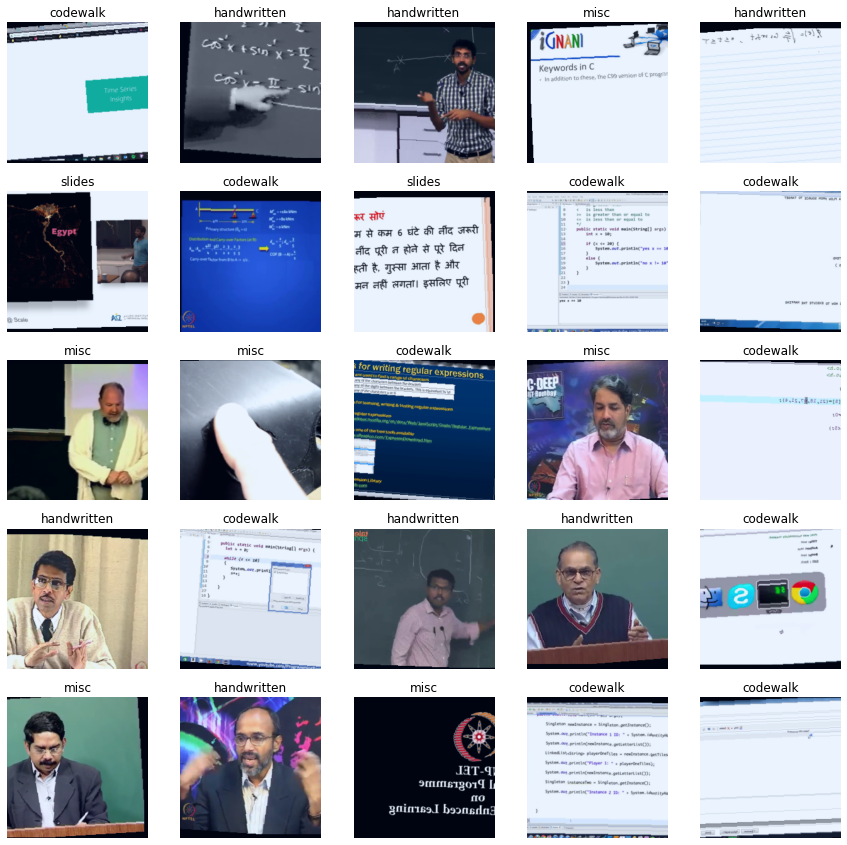

In [15]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])
classes = test_data.classes
plot_images(images, labels, classes)

# Loading Pretrained Model

In [21]:
pretrained_model = models.resnet18(pretrained = True)
IN_FEATURES = pretrained_model.fc.in_features 
OUTPUT_DIM = len(test_data.classes)
fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model.fc = fc
model = pretrained_model

<All keys matched successfully>

In [22]:
LR = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

In [27]:
params = [
          {'params': model.conv1.parameters(), 'lr': LR / 10},
          {'params': model.bn1.parameters(), 'lr': LR / 10},
          {'params': model.layer1.parameters(), 'lr': LR / 8},
          {'params': model.layer2.parameters(), 'lr': LR / 6},
          {'params': model.layer3.parameters(), 'lr': LR / 4},
          {'params': model.layer4.parameters(), 'lr': LR / 2},
          {'params': model.fc.parameters()}
         ]

optimizer = optim.Adam(params, lr = LR)
criterion = nn.CrossEntropyLoss()

In [28]:
EPOCHS = 10
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

# Train, Evaluate and Accuracy Helper Functions

In [29]:
def calculate_topk_accuracy(y_pred, y, k = 1):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].view(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
    return acc_1

In [30]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
        
    return epoch_loss, epoch_acc_1

In [31]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc_1 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
        
    return epoch_loss, epoch_acc_1


In [32]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Training and Validation Evalutation

In [33]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1 = train(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1 = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model-64.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}%')

Epoch: 01 | Epoch Time: 50m 56s
	Train Loss: 0.683 | Train Acc @1:  71.75%
	Valid Loss: 0.571 | Valid Acc @1:  78.48%
Epoch: 02 | Epoch Time: 6m 19s
	Train Loss: 0.556 | Train Acc @1:  77.02%
	Valid Loss: 0.532 | Valid Acc @1:  79.46%
Epoch: 03 | Epoch Time: 6m 17s
	Train Loss: 0.532 | Train Acc @1:  77.56%
	Valid Loss: 0.527 | Valid Acc @1:  78.96%
Epoch: 04 | Epoch Time: 6m 10s
	Train Loss: 0.517 | Train Acc @1:  78.12%
	Valid Loss: 0.528 | Valid Acc @1:  80.09%
Epoch: 05 | Epoch Time: 6m 5s
	Train Loss: 0.457 | Train Acc @1:  80.32%
	Valid Loss: 0.496 | Valid Acc @1:  79.28%
Epoch: 06 | Epoch Time: 6m 2s
	Train Loss: 0.420 | Train Acc @1:  81.62%
	Valid Loss: 0.518 | Valid Acc @1:  80.91%
Epoch: 07 | Epoch Time: 6m 0s
	Train Loss: 0.370 | Train Acc @1:  84.01%
	Valid Loss: 0.539 | Valid Acc @1:  80.06%
Epoch: 08 | Epoch Time: 6m 4s
	Train Loss: 0.315 | Train Acc @1:  86.77%
	Valid Loss: 0.556 | Valid Acc @1:  80.92%
Epoch: 09 | Epoch Time: 6m 0s
	Train Loss: 0.256 | Train Acc @1:  8

# Evaluation on Test Data

In [35]:
model.load_state_dict(torch.load('best-model-64-r18-e5.pt'))

test_loss, test_acc_1 = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}%')

Test Loss: 0.508 | Test Acc @1:  79.25%


# Confusion Matrix

In [39]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [36]:
images, labels, probs = get_predictions(model, test_iterator)
pred_labels = torch.argmax(probs, 1)

In [37]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = '.2f', cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 15)
    plt.ylabel('True Label', fontsize = 15)

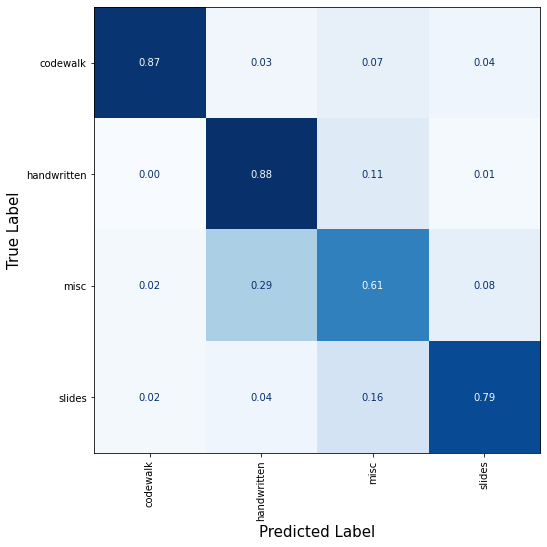

In [38]:
plot_confusion_matrix(labels, pred_labels, classes)

# Plotting Incorrect Examples

In [40]:
corrects = torch.eq(labels, pred_labels)
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [41]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace=0.4)

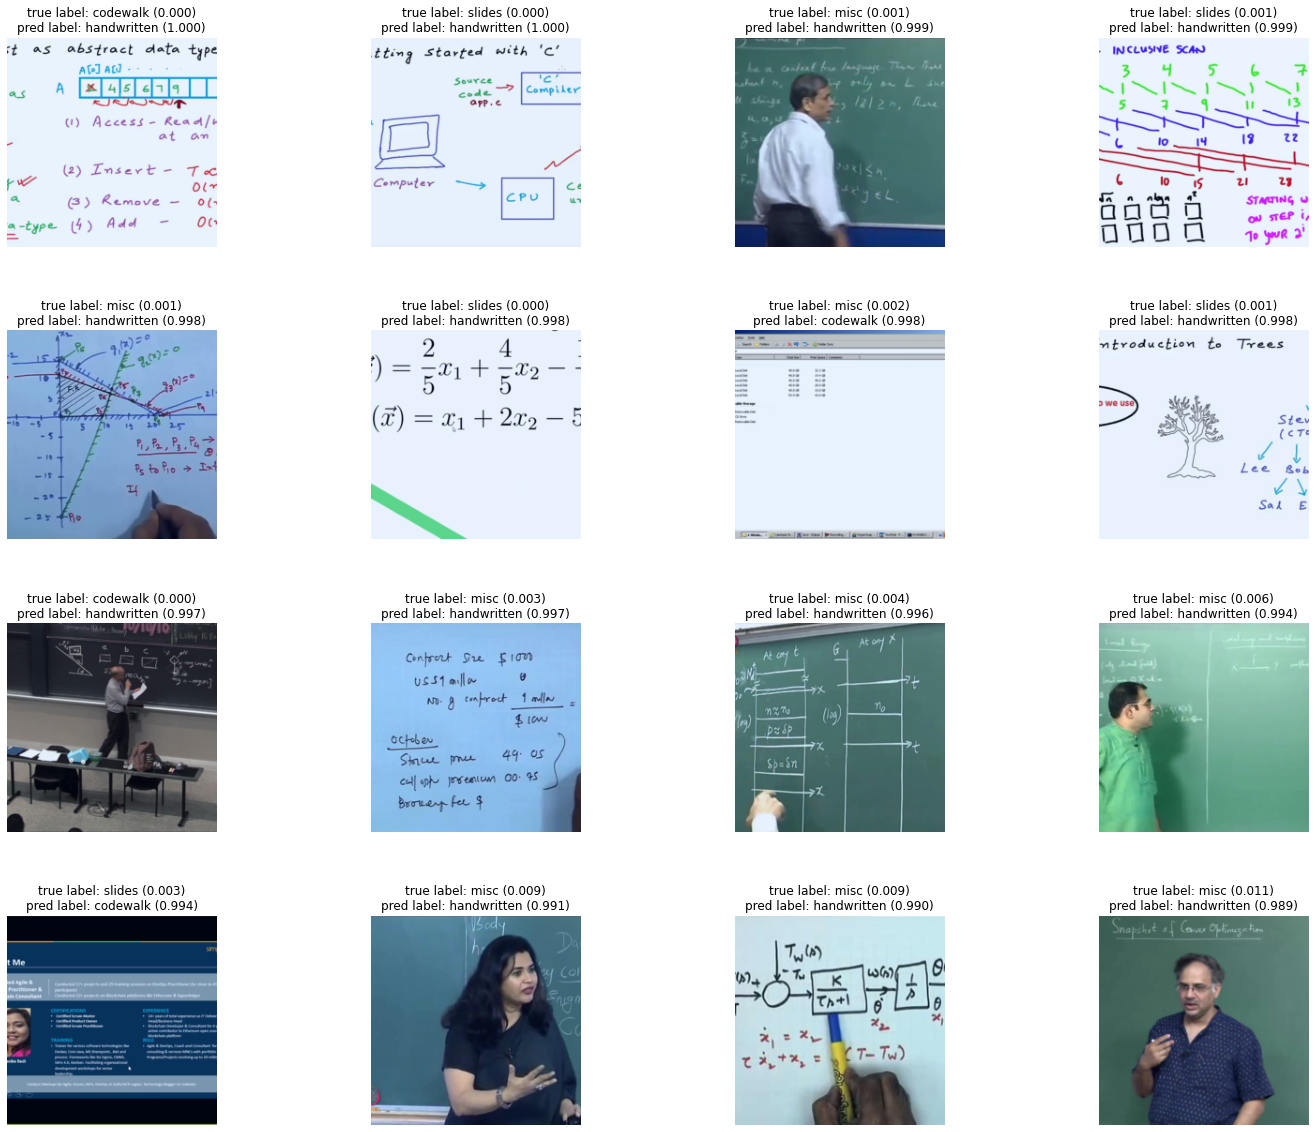

In [42]:
N_IMAGES = 20

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

# Plotting PCA

In [43]:
def get_representations(model, iterator):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            outputs.append(y_pred.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

In [44]:
outputs, labels = get_representations(model, train_iterator)

In [45]:
def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [46]:
output_pca_data = get_pca(outputs)

In [47]:
def plot_representations(data, labels, classes, n_images = None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize = (15, 15))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'rainbow')
    handles, _ = scatter.legend_elements(num = None)
    legend = plt.legend(handles = handles, labels = classes)

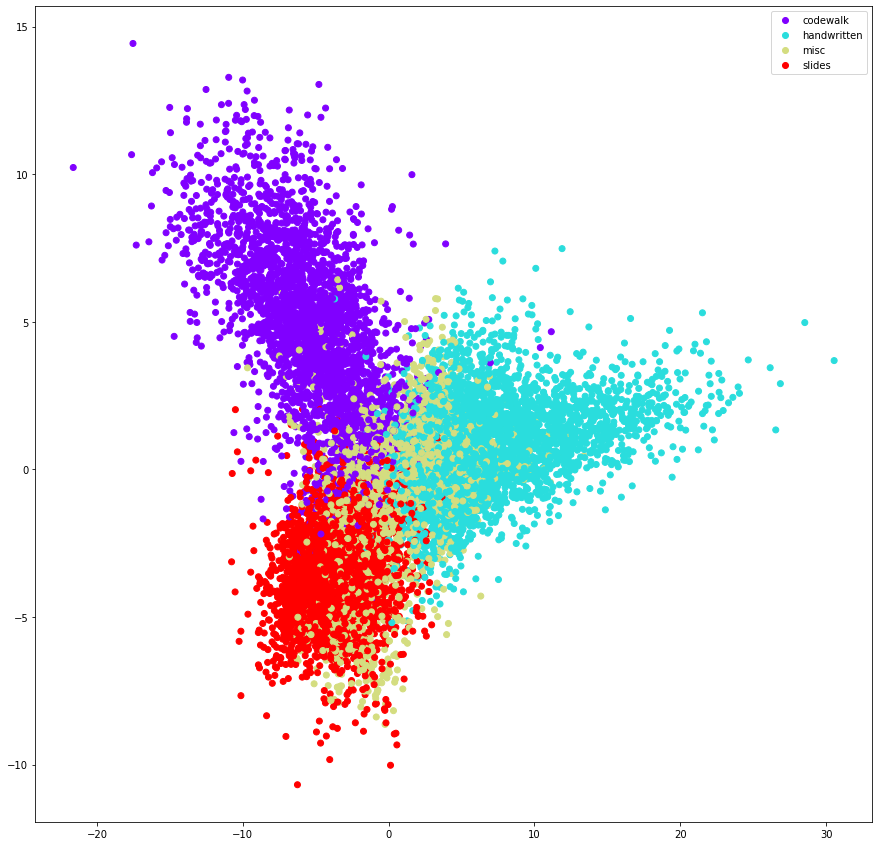

In [48]:
plot_representations(output_pca_data, labels, classes)